In [15]:
import pandas as pd
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath('../..'))
import source.data_preparation as dp

In [16]:
df = pd.read_csv("../../Data/MSCI_World_Data.csv")
df_diff = dp.difference_over_variables(df)
df_diff['timestamp'] = pd.to_datetime(df_diff['timestamp'])
df_diff_onetime = df_diff.copy()

# Loop fit HMM in each step 

In [17]:
from hmmlearn.hmm import GaussianHMM

variable   = 'M1WO'
n_states   = 2
start_date = '2020-02-28'
end_date   = df_diff['timestamp'].max()

# Use 'ME' instead of deprecated 'M'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

state_cols = []   # collect Series here

for t in date_range:
    print(t)
    df_cur  = df_diff.loc[df_diff['timestamp'] <= t, ['timestamp', variable]]
    returns = df_cur[variable].to_numpy().reshape(-1, 1)
    if returns.shape[0] < n_states:
        continue

    # For 1-D data, 'diag' is simpler/faster and helps convergence
    model = GaussianHMM(n_components=n_states, covariance_type='diag',
                        n_iter=1000, random_state=42)
    model.fit(returns)
    z = model.predict(returns).astype(int)
    r = returns.ravel()

    # map states to a consistent convention (1=bull, 0=bear)
    eps = 1e-8
    means, stds = [], []
    for k in range(n_states):
        rk = r[z == k]
        if rk.size == 0:
            means.append(0.0)
            stds.append(1.0)     # neutral placeholder so score=0
        else:
            means.append(rk.mean())
            stds.append(rk.std() + eps)
    scores = np.array(means) / np.array(stds)
    bull_state = int(scores.argmax())
    z_mapped = (z == bull_state).astype(int)

    # build a full-length Series for this horizon, no column insert
    col = f"state_{t.strftime('%Y-%m')}"
    s = pd.Series(np.nan, index=df_diff.index, name=col, dtype='float')
    s.loc[df_diff['timestamp'] <= t] = z_mapped
    state_cols.append(s)

# single concat -> no fragmentation
if state_cols:
    df_diff = pd.concat([df_diff] + state_cols, axis=1)


2020-02-28 00:00:00
2020-02-29 00:00:00
2020-03-01 00:00:00
2020-03-02 00:00:00
2020-03-03 00:00:00
2020-03-04 00:00:00
2020-03-05 00:00:00
2020-03-06 00:00:00
2020-03-07 00:00:00
2020-03-08 00:00:00
2020-03-09 00:00:00
2020-03-10 00:00:00
2020-03-11 00:00:00
2020-03-12 00:00:00
2020-03-13 00:00:00
2020-03-14 00:00:00
2020-03-15 00:00:00
2020-03-16 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-03-21 00:00:00
2020-03-22 00:00:00
2020-03-23 00:00:00
2020-03-24 00:00:00
2020-03-25 00:00:00
2020-03-26 00:00:00
2020-03-27 00:00:00
2020-03-28 00:00:00
2020-03-29 00:00:00
2020-03-30 00:00:00
2020-03-31 00:00:00
2020-04-01 00:00:00
2020-04-02 00:00:00
2020-04-03 00:00:00
2020-04-04 00:00:00
2020-04-05 00:00:00
2020-04-06 00:00:00
2020-04-07 00:00:00
2020-04-08 00:00:00
2020-04-09 00:00:00
2020-04-10 00:00:00
2020-04-11 00:00:00
2020-04-12 00:00:00
2020-04-13 00:00:00
2020-04-14 00:00:00
2020-04-15 00:00:00
2020-04-16 00:00:00
2020-04-17 00:00:00


# Loop for which the model is only trained once

In [18]:
from hmmlearn.hmm import GaussianHMM

variable   = 'M1WO'
n_states   = 2
start_date = '2020-02-28'
end_date   = df_diff_onetime['timestamp'].max()

# Use 'ME' instead of deprecated 'M'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

state_cols = []   # collect Series here
i = 0
for t in date_range:
    print(t)
    df_cur  = df_diff_onetime.loc[df_diff_onetime['timestamp'] <= t, ['timestamp', variable]]
    returns = df_cur[variable].to_numpy().reshape(-1, 1)
    if returns.shape[0] < n_states:
        continue

    # For 1-D data, 'diag' is simpler/faster and helps convergence
    if i == 0:
        i = 1
        print("Training HMM model...")
        model = GaussianHMM(n_components=n_states, covariance_type='diag',
                            n_iter=1000, random_state=42)
        model.fit(returns)
    z = model.predict(returns).astype(int)
    r = returns.ravel()

    # map states to a consistent convention (1=bull, 0=bear)
    eps = 1e-8
    means, stds = [], []
    for k in range(n_states):
        rk = r[z == k]
        if rk.size == 0:
            means.append(0.0)
            stds.append(1.0)     # neutral placeholder so score=0
        else:
            means.append(rk.mean())
            stds.append(rk.std() + eps)
    scores = np.array(means) / np.array(stds)
    bull_state = int(scores.argmax())
    z_mapped = (z == bull_state).astype(int)

    # build a full-length Series for this horizon, no column insert
    col = f"state_{t.strftime('%Y-%m')}"
    s = pd.Series(np.nan, index=df_diff_onetime.index, name=col, dtype='float')
    s.loc[df_diff_onetime['timestamp'] <= t] = z_mapped
    state_cols.append(s)

# single concat -> no fragmentation
if state_cols:
    df_diff_onetime = pd.concat([df_diff_onetime] + state_cols, axis=1)


2020-02-28 00:00:00
Training HMM model...
2020-02-29 00:00:00
2020-03-01 00:00:00
2020-03-02 00:00:00
2020-03-03 00:00:00
2020-03-04 00:00:00
2020-03-05 00:00:00
2020-03-06 00:00:00
2020-03-07 00:00:00
2020-03-08 00:00:00
2020-03-09 00:00:00
2020-03-10 00:00:00
2020-03-11 00:00:00
2020-03-12 00:00:00
2020-03-13 00:00:00
2020-03-14 00:00:00
2020-03-15 00:00:00
2020-03-16 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-03-21 00:00:00
2020-03-22 00:00:00
2020-03-23 00:00:00
2020-03-24 00:00:00
2020-03-25 00:00:00
2020-03-26 00:00:00
2020-03-27 00:00:00
2020-03-28 00:00:00
2020-03-29 00:00:00
2020-03-30 00:00:00
2020-03-31 00:00:00
2020-04-01 00:00:00
2020-04-02 00:00:00
2020-04-03 00:00:00
2020-04-04 00:00:00
2020-04-05 00:00:00
2020-04-06 00:00:00
2020-04-07 00:00:00
2020-04-08 00:00:00
2020-04-09 00:00:00
2020-04-10 00:00:00
2020-04-11 00:00:00
2020-04-12 00:00:00
2020-04-13 00:00:00
2020-04-14 00:00:00
2020-04-15 00:00:00
2020-04-16 00:00:0

In [19]:
import numpy as np
import pandas as pd

# 1) collect and sort your state columns by their horizon date
state_cols = [c for c in df_diff.columns if c.startswith('state_')]
state_cols_onetime = [c for c in df_diff_onetime.columns if c.startswith('state_')]
def _parse_hz(c):
    s = c.split('state_')[1]
    dt = pd.to_datetime(s, format='%Y-%m', errors='coerce')
    if pd.isna(dt):
        dt = pd.to_datetime(s, format='%Y-%m-%d', errors='coerce')
    return dt

state_cols = sorted(state_cols, key=_parse_hz)

# 2) for each row (date), look across horizons and count switches
import numpy as np
import pandas as pd

# Only keep numeric values (0, 1) and NaNs
S = df_diff[state_cols].apply(pd.to_numeric, errors="coerce").to_numpy(dtype=float)
S_onetime = df_diff_onetime[state_cols_onetime].apply(pd.to_numeric, errors="coerce").to_numpy(dtype=float)
def count_switches(row):
    # valid indices where we have both 0/1
    valid = np.isfinite(row)
    if valid.sum() <= 1:
        return 0
    
    # take only valid sequence
    seq = row[valid].astype(int)
    # compute number of adjacent flips
    switches = np.sum(seq[1:] != seq[:-1])
    return int(switches)

switch_counts = np.apply_along_axis(count_switches, 1, S)
switch_counts_onetime = np.apply_along_axis(count_switches, 1, S_onetime)
df_diff["label_switches_across_horizons"] = switch_counts
df_diff_onetime["label_switches_across_horizons"] = switch_counts_onetime


/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_10246/1219498473.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_diff["label_switches_across_horizons"] = switch_counts
/var/folders/q9/d545ygdx5rj6lg_00gpykppw0000gn/T/ipykernel_10246/1219498473.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_diff_onetime["label_switches_across_horizons"] = switch_counts_onetime


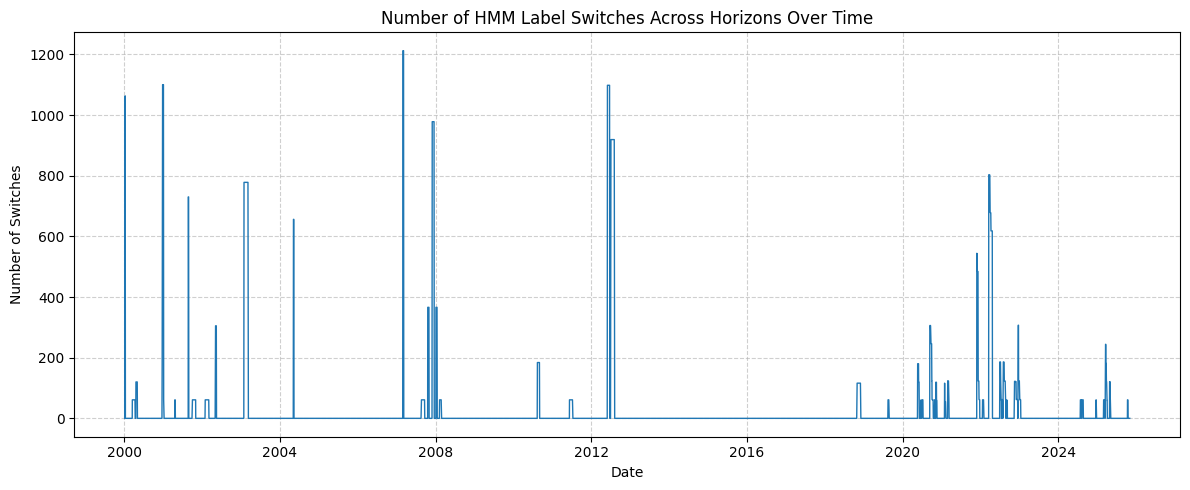

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure the timestamp column is a datetime
df_diff["timestamp"] = pd.to_datetime(df_diff["timestamp"])

plt.figure(figsize=(12, 5))
plt.plot(df_diff["timestamp"], df_diff["label_switches_across_horizons"], linewidth=1)
plt.title("Number of HMM Label Switches Across Horizons Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Switches")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


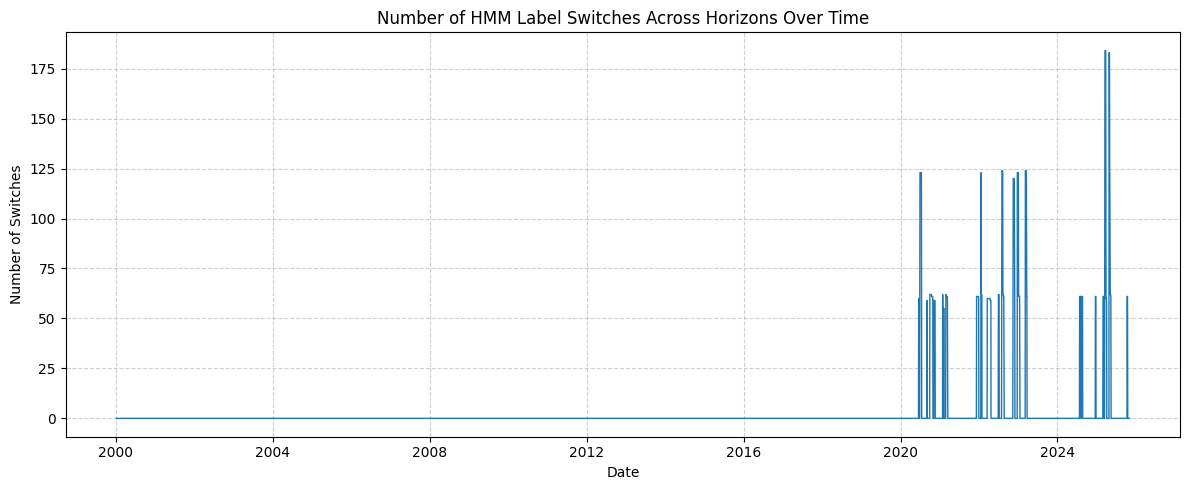

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure the timestamp column is a datetime
df_diff_onetime["timestamp"] = pd.to_datetime(df_diff_onetime["timestamp"])

plt.figure(figsize=(12, 5))
plt.plot(df_diff_onetime["timestamp"], df_diff_onetime["label_switches_across_horizons"], linewidth=1)
plt.title("Number of HMM Label Switches Across Horizons Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Switches")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [10]:
df_diff.shape

(6738, 2089)

Transition matrix (rows sum to 1):
[[0.98708227 0.01291773]
 [0.04166358 0.95833642]]
Model converged: True
Converged in 40 iterations (tol = 0.01 )
State means: [ 0.00071555 -0.00128752]
State stds:  [0.00636463 0.0172233 ]
Bull state: 0, Bear state: 1


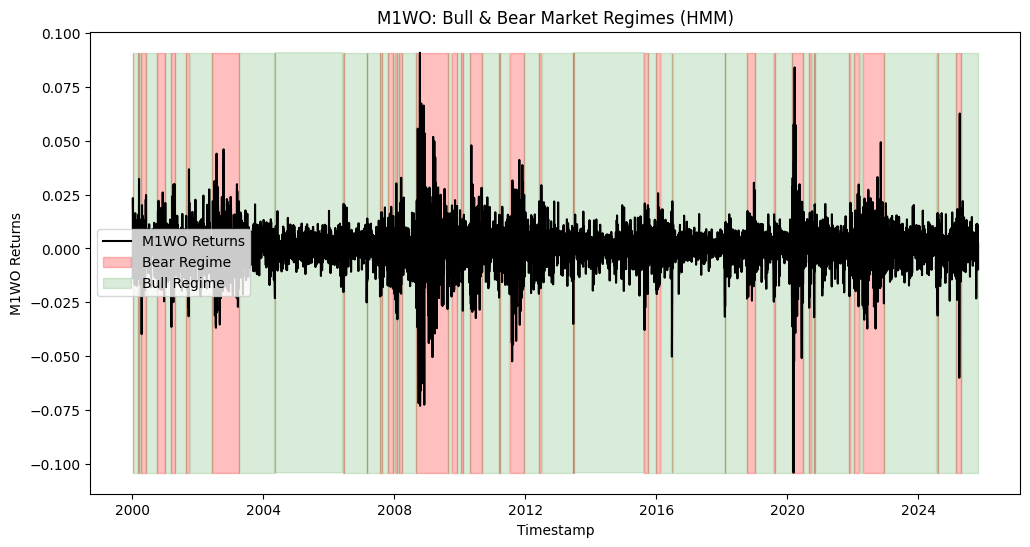

In [12]:
df = dp.create_classification_data(quiet=False)

<module 'source.data_preparation' from '/Users/kilianrunnwerth/Masterarbeit/source/data_preparation.py'>

Transition matrix (rows sum to 1):
[[0.98707897 0.01292103]
 [0.04168033 0.95831967]]
Model converged: True
Converged in 36 iterations (tol = 0.01 )
State means: [ 0.00071921 -0.00130947]
State stds:  [0.00637204 0.01724984]
Bull state: 0, Bear state: 1


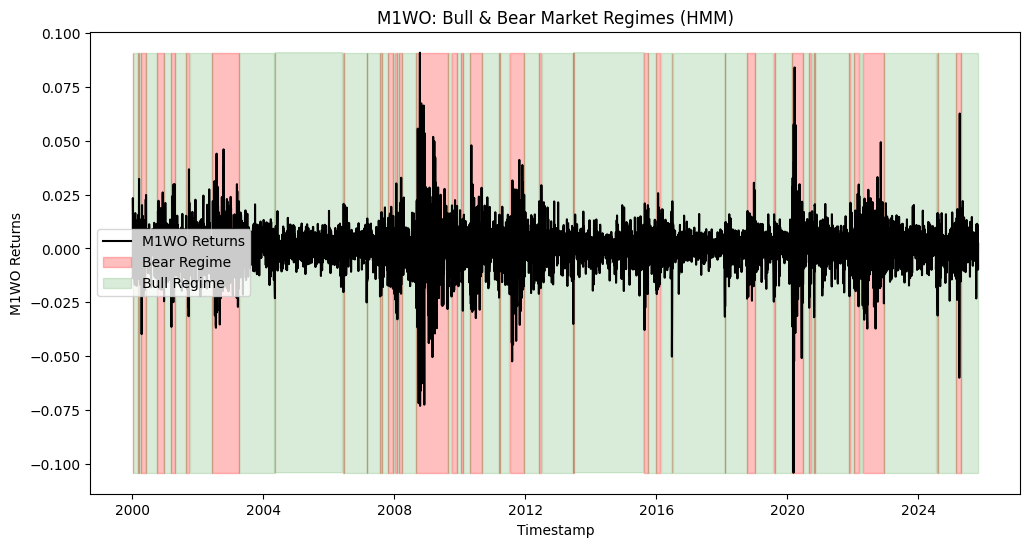

In [32]:
df = dp.create_classification_data(quiet=False, random_state=2232)

In [13]:
returns = df_diff[variable].to_numpy().reshape(-1, 1)

Lade Daten von ../../Data/MSCI_World_Data.csv...
Daten geladen: 6738 Zeitschritte.
Trainiere HMM...
Bear State Index: 1 (Höhere Volatilität)
Unterschiedliche Labels (Leakage Risk): 9.77%


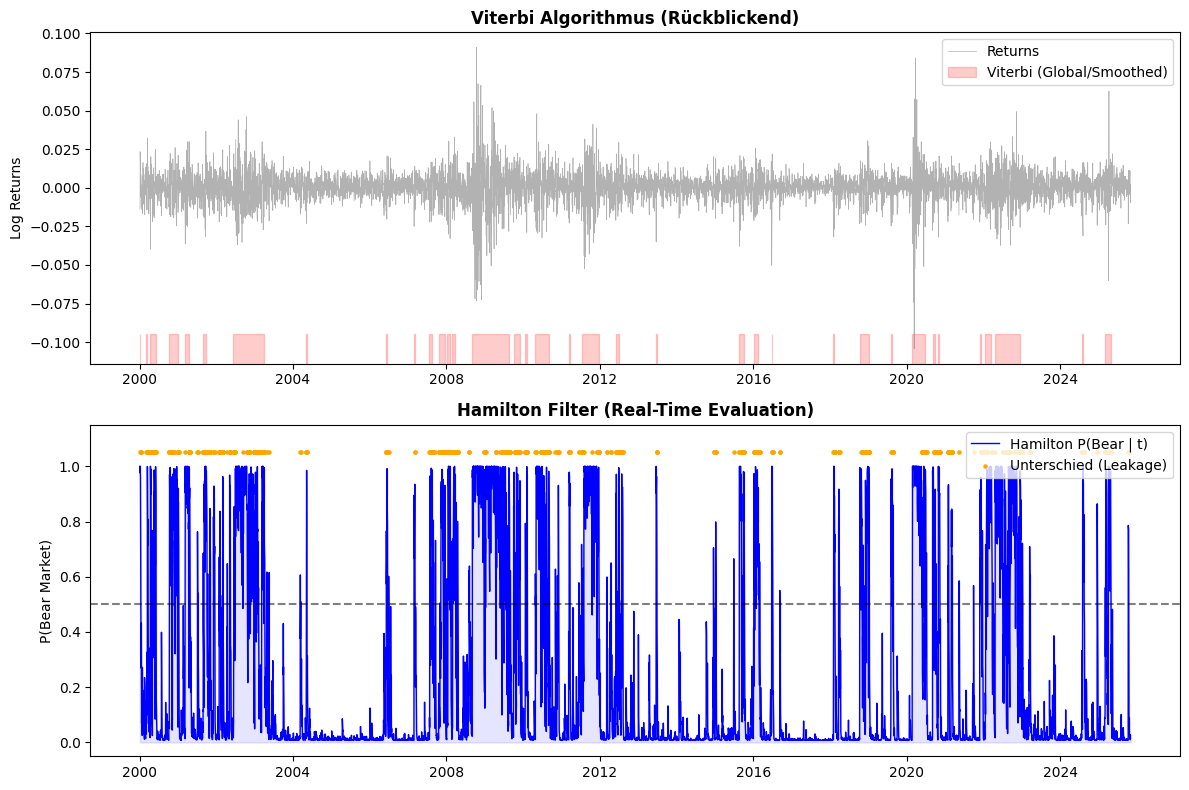

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from hmmlearn.hmm import GaussianHMM
from scipy.stats import norm

# ---------------------------------------------------------
# Konfiguration
# ---------------------------------------------------------
COLUMN_NAME = 'M1WO' 
CSV_PATH = "../../Data/MSCI_World_Data.csv"

# ---------------------------------------------------------
# 1. Hamilton Filter (Forward-Only / Real-Time)
# ---------------------------------------------------------
def run_hamilton_filter(returns, model):
    n_samples = len(returns)
    n_components = model.n_components
    transmat = model.transmat_
    startprob = model.startprob_
    means = model.means_.flatten()
    
    # Varianz extrahieren (diag oder full)
    if model.covariance_type == 'diag':
        covars = model.covars_.flatten()
    else:
        covars = np.array([c[0][0] for c in model.covars_])
    
    filtered_probs = np.zeros((n_samples, n_components))
    current_prob = startprob
    
    for t in range(n_samples):
        y_t = returns[t]
        # A. Prädiktion (Schritt vorwärts basierend auf t-1)
        if t > 0:
            current_prob = np.dot(current_prob, transmat)
            
        # B. Update (Likelihood der aktuellen Beobachtung)
        likelihood = np.zeros(n_components)
        for i in range(n_components):
            likelihood[i] = norm.pdf(y_t, loc=means[i], scale=np.sqrt(covars[i]))
            
        # Bayes Update & Normalisierung
        numerator = current_prob * likelihood
        denominator = np.sum(numerator)
        current_prob = numerator / denominator if denominator != 0 else current_prob
        filtered_probs[t] = current_prob
        
    return filtered_probs

# ---------------------------------------------------------
# 2. Daten Laden & Vorbereiten
# ---------------------------------------------------------
print(f"Lade Daten von {CSV_PATH}...")
df = pd.read_csv(CSV_PATH)

# Log-Returns berechnen
df['returns'] = np.log(df[COLUMN_NAME] / df[COLUMN_NAME].shift(1))
df['timestamp'] = pd.to_datetime(df['timestamp'])

# NaN entfernen (erste Zeile nach Differenzierung)
df_clean = df.dropna(subset=['returns']).reset_index(drop=True)

returns = df_clean['returns'].values
dates = df_clean['timestamp'].values
X = returns.reshape(-1, 1)

print(f"Daten geladen: {len(returns)} Zeitschritte.")

# ---------------------------------------------------------
# 3. HMM Training
# ---------------------------------------------------------
print("Trainiere HMM...")
model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, random_state=42)
model.fit(X)

# Identifiziere Bear Market anhand der höheren Varianz
vars = np.array([c[0] for c in model.covars_])
bear_state = np.argmax(vars) 
print(f"Bear State Index: {bear_state} (Höhere Volatilität)")

# ---------------------------------------------------------
# 4. Vergleich: Viterbi (Global) vs. Hamilton (Real-Time)
# ---------------------------------------------------------

# A. Viterbi (Zukunftswissen / Smoothed)
viterbi_states = model.predict(X)
viterbi_is_bear = (viterbi_states == bear_state).astype(int)

# B. Hamilton (Kein Zukunftswissen / Filtered)
hamilton_probs = run_hamilton_filter(returns, model)
hamilton_bear_prob = hamilton_probs[:, bear_state]
hamilton_is_bear = (hamilton_bear_prob > 0.5).astype(int) # Hard label für Vergleich

# Statistik
disagreement = np.mean(viterbi_is_bear != hamilton_is_bear)
diff_indices = np.where(viterbi_is_bear != hamilton_is_bear)[0]
print(f"Unterschiedliche Labels: {disagreement:.2%}")

# ---------------------------------------------------------
# 5. Plotting
# ---------------------------------------------------------
plt.figure(figsize=(12, 8))

# Plot 1: Returns & Viterbi
ax1 = plt.subplot(2, 1, 1)
ax1.plot(dates, returns, color='grey', alpha=0.6, lw=0.5, label='Returns')
ax1.fill_between(dates, min(returns), max(returns), where=viterbi_is_bear.astype(bool), 
                 color='red', alpha=0.2, label='Viterbi (Global/Smoothed)', transform=ax1.get_xaxis_transform())
ax1.set_title(f'Viterbi Algorithmus (Rückblickend)', fontweight='bold')
ax1.set_ylabel('Log Returns')
ax1.legend(loc='upper right')

# Plot 2: Hamilton Wahrscheinlichkeiten
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(dates, hamilton_bear_prob, color='blue', lw=1.0, label='Hamilton P(Bear | t)')
ax2.fill_between(dates, 0, hamilton_bear_prob, color='blue', alpha=0.1)
ax2.axhline(0.5, color='black', linestyle='--', alpha=0.5)

# Unterschiede markieren
if len(diff_indices) > 0:
    ax2.scatter(dates[diff_indices], [1.05]*len(diff_indices), color='orange', marker='.', s=20, label='Unterschied (Leakage)')

ax2.set_title('Hamilton Filter (Real-Time Evaluation)', fontweight='bold')
ax2.set_ylabel('P(Bear Market)')
ax2.set_ylim(-0.05, 1.15)
ax2.legend(loc='upper right')

# Formatierung
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()